In [1]:
import json, requests, time, bs4, pywren, nltk, gensim
import pandas as pd
from re import findall
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from requests.exceptions import SSLError, MissingSchema, ConnectionError
from collections import Counter
stop_words = set(stopwords.words('english'))
import en_core_web_sm
nlp = en_core_web_sm.load()

In [2]:
def normalizeTokens(word_list, extra_stop=[], model=nlp, MAX_LEN=1500000):
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem.encode('ascii', 'ignore').decode("utf-8")) 
                              for elem in word_list]) 

    model.max_length = MAX_LEN
    doc = model(word_list.lower(), disable=["parser", "tagger", "ner"])
    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    for w in doc:
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            add = str(w.lemma_)
            if ('/' in add) and ('.' in add): continue ## exclude href in tweets
            else: normalized.append(add)
    return normalized

## Think Tank Articles
#### Generate Word2Vec Model

In [3]:
article_dct = json.load(open('article_dct_full.json'))
data = pd.DataFrame({'href': list(article_dct.keys())})
data['len'] = data['href'].apply(lambda x: len(article_dct[x]))
data = data[data['len']>5].copy()
data['sent'] = data['href'].apply(lambda x: sent_tokenize(article_dct[x]))
data['raw_text'] = data['href'].apply(lambda x: article_dct[x])
subset_data = data.drop_duplicates(subset=['raw_text']).copy()
len(subset_data), len(data)

(39442, 42543)

In [ ]:
text = subset_data['sent'].sum()
sent_freq = Counter(text)

In [9]:
too_freq_sent = [sent for sent in sent_freq if sent_freq[sent]>20]
print(len(too_freq_sent))
subset_data['cleaned_sent'] = subset_data['sent'].apply(lambda x: list(set(x)-set(too_freq_sent)))

7344


In [12]:
subset_data['len'] = subset_data['cleaned_sent'].apply(len)
subset_data = subset_data[subset_data['len']>3].copy()
subset_data['cleaned_sent_token'] = subset_data['cleaned_sent'].apply(lambda x: 
                                    [normalizeTokens(sent) for sent in x])
text = subset_data['cleaned_sent_token'].sum()
words_W2V = gensim.models.word2vec.Word2Vec(text)
words_W2V.save("article_WORD2Vec_v22")
#words_W2V = gensim.models.word2vec.Word2Vec.load('article_WORD2Vec_v22')

In [13]:
words_W2V.wv.most_similar('president')

[('presidency', 0.7374430894851685),
 ('administration', 0.7181103229522705),
 ('barack', 0.6380500197410583),
 ('mr', 0.6248232126235962),
 ('president-', 0.5782852172851562),
 ('predecessor', 0.555210292339325),
 ('versa', 0.5544413924217224),
 ('renominated', 0.5432539582252502),
 ('reelect', 0.5355809926986694),
 ('presidential', 0.5148879289627075)]

In [17]:
words_W2V.wv.most_similar('liberal')

[('conservative', 0.7767157554626465),
 ('progressive', 0.7267498970031738),
 ('libertarian', 0.7123078107833862),
 ('traditionalist', 0.7112573981285095),
 ('liberalism', 0.7033894062042236),
 ('internationalist', 0.7017655968666077),
 ('centrist', 0.6984409093856812),
 ('illiberal', 0.671079695224762),
 ('secularist', 0.665131688117981),
 ('conservatism', 0.6596860885620117)]

#### Word Cloud

In [18]:
import sklearn.decomposition, sklearn.manifold
import matplotlib.pyplot as plt
numWords = 50
targetWords = words_W2V.wv.index2word[:numWords]
wordsSubMatrix = []
for word in targetWords: wordsSubMatrix.append(words_W2V.wv[word])
wordsSubMatrix = np.array(wordsSubMatrix)
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

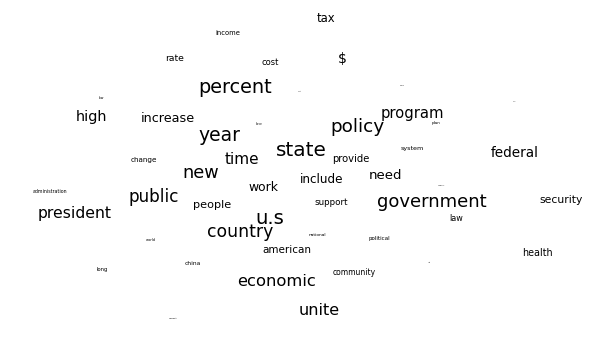

In [19]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111); ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), 
                size =  20 * (numWords - i) / numWords)
plt.xticks(()); plt.yticks(()); plt.show()

#### Connect to Experts

In [20]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [21]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(sent_list, model = words_W2V.wv):
    word_list = [j for i in sent_list for j in i]
    return sum([normalize(model[x]) for x in word_list if x in model.wv])

In [22]:
subset_data['dim'] = subset_data['cleaned_sent_token'].apply(dimension)

In [23]:
expert_data = json.load(open('expert_all.json'))

In [25]:
href_dim = dict(zip(subset_data['href'], subset_data['dim']))
expert_dim = dict()
for expert in expert_data:
    hrefs = [i for i in expert_data[expert]['articles']]
    s = sum([href_dim[href] for href in hrefs if href in href_dim])
    if isinstance(s, int): continue
    else: expert_dim[expert] = s
    #else: expert_dim[expert] = str(s).strip("[|]")

In [57]:
json.dump(expert_dim, open('expert_article_dim.json', 'w'))

In [26]:
from sklearn.metrics.pairwise import cosine_similarity
def find_closest_similarity(expert):
    cos = [(x, cosine_similarity(expert_dim[expert].reshape(1,-1), 
                                 expert_dim[x].reshape(1,-1))[0][0]) for x in expert_dim.keys()]
    return sorted(cos, key = lambda x: -x[1])[:10]

def find_least_similarity(expert):
    cos = [(x, cosine_similarity(expert_dim[expert].reshape(1,-1), 
                                 expert_dim[x].reshape(1,-1))[0][0]) for x in expert_dim.keys()]
    return sorted(cos, key = lambda x: x[1])[:10]

In [28]:
find_least_similarity('haroon-bhorat')

[('rachel-del-guidice', -0.23853864),
 ('koronowski-ryan', -0.10703542),
 ('stephen-hess', -0.06367823),
 ('alexander-phipps', -0.058695465),
 ('margaret-l-taylor', -0.053991195),
 ('paul-gallagher', -0.052105825),
 ('michelle-cordero', -0.042839114),
 ('thomas-jipping', -0.011971792),
 ('hardy-jasmine', -0.010270828),
 ('lee-edwards', 0.023669835)]

In [40]:
def cal_similarity(exs):
    try: return cosine_similarity(expert_dim[exs[0]].reshape(1,-1), 
                                  expert_dim[exs[1]].reshape(1,-1))[0][0]
    except KeyError: return np.NAN

In [38]:
full_data = full_data.drop(['type_x', 'type_y'], axis=1)

In [41]:
full_data = pd.read_csv('data4analysis.csv')
words_W2V = gensim.models.word2vec.Word2Vec.load('article_WORD2Vec_v22')
full_data['topic_similarity'] = full_data[['expert_id_x', 
                                           'expert_id_y']].apply(cal_similarity, axis=1)

In [42]:
full_data.to_csv('data4analysis.csv')

## Twitter

In [2]:
twitter_dct = json.load(open('expert_profile_tweets.json'))
data = pd.read_csv('complete_data.csv')

In [3]:
from datetime import datetime
def check_2020(date):
    if len(date.split(' ')) > 2: return False
    try: assume_time = datetime.strptime(date+' 2020', '%b %d %Y')
    except ValueError: return False ## it is 2020 but after Aug 31
    if assume_time > datetime.strptime('Aug 31 2020', '%b %d %Y'): return False
    return True
def avg_freq(expert):
    return len([i[1] for i in twitter_dct[expert]['tweets'] 
                if check_2020(i[1])])/8

In [8]:
#freq = {ex: avg_freq(ex) for ex in twitter_dct}
data['tweet_freq'] = data['twitter'].apply(lambda x: freq[x] 
                                    if x in twitter_dct else np.NAN)

In [10]:
data.to_csv('complete_data.csv', index=False)

In [48]:
raw_texts = []
for exp in twitter_dct:
    raw_texts.extend([i[2][0] for i in twitter_dct[exp]['tweets'] if check_2020(i[1])])
len(raw_texts)

432721

In [49]:
#text = [normalizeTokens(i) for i in raw_texts if i]
#words_W2V = gensim.models.word2vec.Word2Vec(text)
#words_W2V.save("tweet_WORD2Vec")
words_W2V = gensim.models.word2vec.Word2Vec.load('tweet_WORD2Vec')

In [55]:
def tweet_dim(exp):
    tweets = [normalizeTokens(i[2][0]) for i in twitter_dct[exp]['tweets'] 
              if check_2020(i[1]) and i[2][0]]
    return dimension(tweets)

def find_closest_similarity(expert):
    cos = [(x, cal_similarity((expert, x)))
           for x in expert_tweet_dim.keys()]
    return sorted(cos, key = lambda x: -x[1])[:10]

def cal_similarity(exs):
    try: return cosine_similarity(expert_tweet_dim[exs[0]].reshape(1,-1), 
                                  expert_tweet_dim[exs[1]].reshape(1,-1))[0][0]
    except (KeyError, AttributeError): return np.NAN

In [51]:
expert_tweet_dim = {exp: tweet_dim(exp) for exp in twitter_dct}

In [60]:
full_data['tweet_similarity'] = full_data[['twitter_x', 'twitter_y']].apply(cal_similarity, 
                                                                            axis=1)

In [66]:
non_na_data = full_data.dropna()
np.corrcoef(non_na_data['tweet_similarity'], non_na_data['topic_similarity'])

array([[1.        , 0.28300782],
       [0.28300782, 1.        ]])

<AxesSubplot:xlabel='tweet_similarity', ylabel='topic_similarity'>

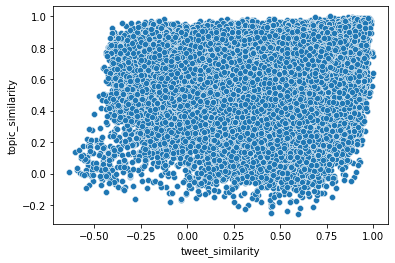

In [62]:
import seaborn as sns
sns.scatterplot(x='tweet_similarity', y='topic_similarity', data = full_data)

In [56]:
find_closest_similarity('SamuelAbramsAEI')

[('drturnerlee', 0.91106284),
 ('xavbriggs', 0.8937225),
 ('TawannaABlack', 0.877063),
 ('alexandriajwitt', 0.8520355),
 ('EGWBrookings', 0.8418879),
 ('VJS_Policy', 0.84012616),
 ('danielbenaim', 0.83668554),
 ('econsarahreber', 0.8283887),
 ('JohnJHudak', 0.8281248),
 ('zpneal', 0.8268456)]

In [69]:
full_data.to_csv('data4analysis.csv', index=False)